<a href="https://colab.research.google.com/github/Alecia113/NLP-Emotional-analysis/blob/main/%E6%95%B4%E7%90%86427.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Code to download file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = '1lTD6bgRkmwguGAr30v-r0KBPdtnVneLb'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('testing_data.pkl')  

id = '1pCUdlZMoj99UZHtqFeza86fvVQfFmDFX'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('training_data.pkl')  

import pickle #必要的
training_data = pickle.load(open("training_data.pkl","rb")) #必要的
testing_data = pickle.load(open("testing_data.pkl","rb")) #必要的

print("------------------------------------")
print("Size of training dataset: {0}".format(len(training_data))) #8000
print("Size of testing dataset: {0}".format(len(testing_data))) #2000
print("------------------------------------")

print("------------------------------------")
print("Sample Data")
print("LABEL: {0} / SENTENCE: {1}".format(training_data[0][0], training_data[0][1]))
print("------------------------------------")
#LABEL: neg / SENTENCE: hopeless for tmr :(

------------------------------------
Size of training dataset: 8000
Size of testing dataset: 2000
------------------------------------
------------------------------------
Sample Data
LABEL: neg / SENTENCE: hopeless for tmr :(
------------------------------------


In [ ]:
# Please comment your code
#I think of the training set like people taking practice exams. And the test set is equivalent to a final exam. So they should be handled in the same way so that the model effects can be observed effectively.
#[lab5]
import torch
from random import shuffle
import pprint
from nltk.tokenize import TweetTokenizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords as sw
import re

from nltk.tokenize import word_tokenize
from collections import Counter
import math
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Separate data and labels into two lists. As it is the given data set are in the form of data + labels, so to separate it
train_data = [training_data[i][1] for i in range(len(training_data))]
train_label = [training_data[i][0] for i in range(len(training_data))]
test_data = [testing_data[i][1] for i in range(len(testing_data))]  
test_label = [testing_data[i][0] for i in range(len(testing_data))]         #neg pos


# [lab3]random training set To make the model trained better, because the training set given in front of the front is separated before and after 000111, the front is all negative after all positive
# It seems that it is okay not to add it, but the accuracy is improved by adding it. Before adding is to adjust the training set according to the batch_size, otherwise it will appear when training the model, the accuracy of 0.5/1 constant situation. Although the loss is changing, the classification situation remains the same.
zipped = zip(train_data,train_label)                          #The zip function can only be used once. If you print(list(zipped)) directly, zipped will be empty afterwards, because the iterator has already been used once; if you want to reuse the result, you need to save it to a list.
Zipp = list(zipped) 
shuffle(Zipp)
train_data = [context[0] for context in Zipp]
train_label = [context[1] for context in Zipp]


def preprocessing(data_text):
  text = [s.lower() for s in data_text]                       #do preprocessing to lowercase [lab5]. Because it is easier to match elements in the dictionary if they are lowercase. It will not be the case that some words are lowercase and some are uppercase, which makes the data set more neat and makes it easier to delete words for subsequent processing.
  '''
  def remove_punctuation_re(x):                   #Delete the punctuation. 
    x1 = re.sub(r'[^\w\s]','',x)            
    x2 = re.sub(r'\d','',x1)                
    return x2

  text_re = [remove_punctuation_re(s) for s in text]
  '''
  tknzr = TweetTokenizer()
  text_t=[]                               #The set of subwords for each sentence completely. train_t[0][0] each word
  for s in text:                          #text ==text_re
    text = tknzr.tokenize(s)              #Each sentence is split separately text_train[0] split of the first sentence
    text_t.append(text)  
    
                                           #Only the expressions of length 2 and 3 are kept. Because I browsed through the main emojis, I selected the most common ones as reservations.
  def remove(x):
    t = []
    for i in range(len(x)):
      t_sub = []                            #I first thought it was to get my pre-processed words to match up with the positives and negatives in Lexicon, but after investigating and testing, I found it was the equivalent of taking the pre-processed participles and the words in Lexicon, similar to putting them in a comprehensive dictionary.
      for j in range(len(x[i])):            # A new reference dictionary that facilitates model classification training is then formed.
        if len(x[i][j])==0:
          continue
        if x[i][j] == " ":
          continue 
        else:
          x[i][j] = re.sub(r'\d','',x[i][j])                  #delete0-9
          if len(x[i][j]) == 1 or len(x[i][j]) > 3:           #and + or。
            x[i][j] = re.sub(r'[^\w\s+]','', x[i][j])
          if len(x[i][j]) == 0:
            continue 
          else:
            t_sub.append(x[i][j]) 
      t.append(t_sub) 
    return t

  new_text = remove(text_t)

  stop_words = sw.words()                     #stopword: Delete words that are optional and do not affect the meaning of the sentence, but are very numerous. For example, a; an; the.
  sww = sw.words()
  text_stop=[]                        #8000
  for tokens in new_text:             #new_text == text_t
      filtered_sentence = [w for w in tokens if not w in stop_words]
      text_stop.append(filtered_sentence)
  return text_stop

pre_train= preprocessing(train_data)  
pre_test =preprocessing(test_data)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
'''
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

def lemmatize(past_text):
  lemmatizer = WordNetLemmatizer()

  text_le = []
  for tokens in past_text:
    lemma_sentence = [lemmatizer.lemmatize(w) for w in tokens ]
    text_le.append(lemma_sentence)
  return text_le

lem_train = lemmatize(pre_train)  #nobodies-->nobody
lem_test = lemmatize(pre_test)
'''

"\nnltk.download('wordnet')\nfrom nltk.stem import WordNetLemmatizer\n\ndef lemmatize(past_text):\n  lemmatizer = WordNetLemmatizer()\n\n  text_le = []\n  for tokens in past_text:\n    lemma_sentence = [lemmatizer.lemmatize(w) for w in tokens ]\n    text_le.append(lemma_sentence)\n  return text_le\n\nlem_train = lemmatize(pre_train)  #nobodies-->nobody\nlem_test = lemmatize(pre_test)\n"

In [ ]:

# stem
from nltk.stem.porter import *
def stemming(past_text):
  stemmer = PorterStemmer()
  train_stem = []
  for i in range(len(past_text)):
    singles = []
    for plural in past_text[i]:
      singles.append(stemmer.stem(plural))
    train_stem.append(singles)
  return train_stem

stem_train = stemming(pre_train)  #nobodies -->nobodi
stem_test = stemming(pre_test)


In [ ]:
#为什么要stem
'''
II = torch.load('save_stem.PATH')  # 'save_lem.PATH'
O=model.load_state_dict(II['model_state_dict']) #成功
optimizer.load_state_dict(II['optimizer_state_dict'])
PP = II['epoch'] #19
LL = II['loss'] #0.6927
P2 = II['predicted2']   #tensor([0, 1, 0,  ..., 0, 1, 0])
O2 = II['outputs2']   

tensor([[ 0.1570, -0.1038],
        [-0.2550,  0.3335],
        [ 0.1559, -0.0992],
        ...,
        [ 0.1649, -0.1156],
        [-0.1996,  0.2628],
        [ 0.1186, -0.0533]], requires_grad=True)

P = II['predicted'] #tensor([0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,// 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
ACC = II['acc'] #0.61  看起来是存了期中的一个
TL = II['train_loss'] #6.557632803916931  看起来是存了期中的一个
#不再存直接跑是上次的状态
print(PP)
print(LL)
print(P2)
print(O2)
print(P)
print(ACC)
print(TL)
'''

"\nII = torch.load('save_stem.PATH')  # 'save_lem.PATH'\nO=model.load_state_dict(II['model_state_dict']) #成功\noptimizer.load_state_dict(II['optimizer_state_dict'])\nPP = II['epoch'] #19\nLL = II['loss'] #0.6927\nP2 = II['predicted2']   #tensor([0, 1, 0,  ..., 0, 1, 0])\nO2 = II['outputs2']   \n\ntensor([[ 0.1570, -0.1038],\n        [-0.2550,  0.3335],\n        [ 0.1559, -0.0992],\n        ...,\n        [ 0.1649, -0.1156],\n        [-0.1996,  0.2628],\n        [ 0.1186, -0.0533]], requires_grad=True)\n\nP = II['predicted'] #tensor([0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,// 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,\nACC = II['acc'] #0.61  看起来是存了期中的一个\nTL = II['train_loss'] #6.557632803916931  看起来是存了期中的一个\n#不再存直接跑是上次的状态\nprint(PP)\nprint(LL)\nprint(P2)\nprint(O2)\nprint(P)\nprint(ACC)\nprint(TL)\n"

想测试哪个预处理好用。

In [ ]:
sentences = stem_train + stem_test      #
'''
from gensim.models import Word2Vec
wv_cbow_model = Word2Vec(sentences= sentences, size=100, window=5, min_count=2, workers=2, sg=0)
wv_cbow_model.save("cbow.model")
#cbow = Word2Vec.load("./cbow.model")  
'''

from gensim.models import FastText
ft_sg_model = FastText(sentences=sentences, size=100, window=5, min_count=2, workers=2, sg=1)
ft_sg_model.save('ft_sg.model')
ft_sg = FastText.load("./ft_sg.model")  


In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

not_words = [w.strip() for w in open('/content/drive/MyDrive/NLP/A1/E/opinion-lexicon-English/negative-words.txt', 'r', encoding="ISO-8859-1").readlines()]
#处理文件 -
j = -1
for i in not_words:
  j +=1
  if i == '2-faced':
    break
neg = not_words[j:]

#处理文件+
sure_words = [w.strip() for w in open('/content/drive/MyDrive/NLP/A1/E/opinion-lexicon-English/positive-words.txt', 'r', encoding="ISO-8859-1").readlines()]

j = -1
for i in sure_words:
  j +=1
  if i == 'a+':
    break

pos = sure_words[j:]


nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
'''
def lem(past_text):
  lemmatizer = WordNetLemmatizer()

  text_le = []

  lemma_sentence = [lemmatizer.lemmatize(w) for w in past_text ]
  text_le.append(lemma_sentence)
  return text_le
neg_new = lem(neg)
pos_new = lem(pos)
'''


from nltk.stem.porter import *
def stem(past_text):
  stemmer = PorterStemmer()
  text_le = []
  stemmer_sentence = [stemmer.stem(plural) for plural in past_text ]
  text_le.append(stemmer_sentence)
  return text_le

neg_new = stem(neg)
pos_new = stem(pos)

Mounted at /content/drive
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
#只是原来的，因为neg就是单词了。不能再neg[0]
'''
大改动
'''
def match(text):
  sum_match= [] #train_match
  for i in range(len(text)):  #train_stem  取出一句话
    match = []
    for j in range(len(text[i])):   #取出一句话中的单词
      if text[i][j] in neg_new[0]:    #neg_stem  第几句话的第几个单词
        match.append(1)   #neg 1
      elif text[i][j] in pos_new[0]:  #pos_stem
        match.append(2) #pos 2
      else:
        match.append(0)
    sum_match.append(match)
  return sum_match
train_match = match(stem_train)  #这在不断的改变 train_stem  原本的话都是000
test_match = match(stem_test)
#只有stem好用
#print(train_match)
#print(test_match[:5])
#就是把我原本的要训练的话，纷纷用012 表示出来。每个词告诉他是积极消极还是不在

In [ ]:
#实现的是concat的功能。
'''
大改动
'''
def input(text,text_match):
  DF = {}

  for tokensized_doc in text: 
      for term in np.unique(tokensized_doc):
          try:
              DF[term] +=1
          except:
              DF[term] =1
  input = []
  for w in range(len(text)):                #8000 0-7999
    num = 0
    new = []
    for t in text[w]:                       #一句话 #t就是这个单词  #13
      match = []                            #目前这个就是第一句话的match
      if DF[t] >= 2:                         #0-12     这个min_count
        word_vec = ft_sg[t].tolist()
        match.append(text_match[w][num])     #w 012 []   #IndexError: list index out of range 后面的num问题
        new_embedding = word_vec + match       #sent_embedding
        new.append(new_embedding)
      num += 1
      if num >= len(text_match[w]):
        break
    input.append(new)                          # input == train_embedding
                                                #print(input[0][0]) #input 8000一句话 3一个词 101 vec+0、1

  return input

input_train = input(stem_train,train_match)         #train_stem变化
input_test = input(stem_test,test_match)           #test_stem变化
#pprint.pprint(input_train[:1])
#print('\n')
#pprint.pprint(input_test[:1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [ ]:
#主要是为了得到n_class
unique_labels = np.unique(train_label)

lEnc = LabelEncoder()
label_train_encoded = lEnc.fit_transform(train_label)         #lEnc.transform(unique_labels)[0]+1
label_test_encoded = lEnc.fit_transform(test_label)
n_class = len(unique_labels)                                   #主要是为了得到n_class  #n_class = np.unique(unique_labels).shape[0] #2相当于

#要确定最大长度是多少 [lab4]
doc_length_list = []                                              #会得到8000句话
sum_text = sentences     #train_stem + test_stem要改的
maxlength = 0
for doc in sum_text:
    doc_length_list.append(len(doc))                                  #每句话多少个分词

for index in range(len(doc_length_list)):
  if doc_length_list[index] > maxlength:
    maxlength = doc_length_list[index]
    max_index = index
#print(doc_length_list[max_index]) #21


In [ ]:
#超参

seq_length = doc_length_list[max_index]           #（22）应该是我规定的最大序列长度512那种  maxlength 增加减少那种 #一句话最长多少个词
n_input = len(input_train[0][0])              #101 无所谓的反正都是101维度
n_class = len(unique_labels)                  #2

n_hidden = 200                                  #128
batch_size = 800                                #500 
total_epoch = 20                                #10
learning_rate = 0.001                           # 1e-4 == 0.001 le-3 == 0.01 #0.1  0.05


#把输入的规格都定成一样的， 变成句子长度是22，单词维度是101

def sent_encoded(input_text):
  sent_encoded = []
  for m in range(len(input_text)):                       # m 1-8000 #训练集  input_train  input_test
    
    encoded = [] 
    zero = []
    if len(input_text[m]) < seq_length:
      zero = [len(input_text[0][0])*[0]] * (seq_length - len(input_text[m]))#补充到22 最长 # 不单单加0； 还是需要变成101维度
      encoded = input_text[m] + zero
    else:
      encoded = input_text[m]
    sent_encoded.append(encoded)                                              #要重新添加。 句子已经全变成22了 

  sent_encoded = np.array(sent_encoded)
  return sent_encoded

sent_encoded_train = sent_encoded(input_train)
sent_encoded_test = sent_encoded(input_test)
#print(sent_encoded_train[:1]) #(8000, 22, 101)
#print(sent_encoded_test[:1])#(2000, 22, 101)


#还是Bi-LSTM准确度更高，因为LSTM处理了记忆丢失的问题。
'''
要写个LSTM比RNN好在哪里。
'''
# 模型Bi-RNN


'''
class Bi_RNN_Model(nn.Module):
    def __init__(self):
        super(Bi_RNN_Model, self).__init__()
        # set the bidirectional to True
        self.rnn = nn.RNN(n_input, n_hidden, batch_first =True, bidirectional=True) #, dropout = 0.5
        self.linear = nn.Linear(2*n_hidden,n_class) #n_class = 3 
        #https://stackoverflow.com/questions/60259836/cnn-indexerror-target-2-is-out-of-bounds 虽然是01分类但是，pytorch 要进行012 
    def forward(self, x):        
        x, h_n = self.rnn(x)
        # concat the last hidden state from two direction
        hidden_out = torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        output = self.linear(hidden_out)
        return output


'''

#LSTM-BI
class Bi_LSTM_Model(nn.Module):
    def __init__(self):
        super(Bi_LSTM_Model, self).__init__()
        #self.emb = nn.Embedding(vocab_size, emb_dim)
        # Initialize the Embedding layer with the lookup table we created 
        #self.emb.weight.data.copy_(torch.from_numpy(emb_table))
        # Optional: set requires_grad = False to make this lookup table untrainable
        #self.emb.weight.requires_grad = False

        self.lstm = nn.LSTM(n_input, n_hidden, batch_first =True, bidirectional=True)
        self.linear = nn.Linear(n_hidden*2, n_class)

    def forward(self, x):
        # Get the embeded tensor
        #x = self.emb(x)        
        # we will use the returned h_n of shape (num_layers * num_directions, batch, hidden_size): tensor containing the hidden state for t = seq_len.
        # details of the outputs from nn.LSTM can be found from: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        lstm_out, (h_n,c_n) = self.lstm(x)
        # concat the last hidden state from two direction
        hidden_out =torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        z = self.linear(hidden_out)
        return z


'''
criterion = nn.CrossEntropyLoss()
model = Bi_RNN_Model().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
'''
#Bi-LSTM
# Move the model to GPU
criterion = nn.CrossEntropyLoss()
model = Bi_LSTM_Model().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)




In [ ]:
class Bi_RNN_Model(nn.Module):
    def __init__(self):
        super(Bi_RNN_Model, self).__init__()
        # set the bidirectional to True
        self.rnn = nn.RNN(n_input, n_hidden, batch_first =True, bidirectional=True) #, dropout = 0.5
        self.linear = nn.Linear(2*n_hidden,n_class) #n_class = 3 
        #https://stackoverflow.com/questions/60259836/cnn-indexerror-target-2-is-out-of-bounds 虽然是01分类但是，pytorch 要进行012 
    def forward(self, x):        
        x, h_n = self.rnn(x)
        # concat the last hidden state from two direction
        hidden_out = torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        output = self.linear(hidden_out)
        return output

In [ ]:
# Please comment your code
#[lab4][lab5]
#检查输出节点数与标签数是否一致。
#并且将输出节点数num_outputs更改为标签数。
# 因为我之前设置的class 类别是 0，1；所以这里也需要改成0，1 要不然后面会出现 target超出范围的错误。
def label(label):   
  label = np.array(label) #train_label
  #neg 1 pos2
  lab = []  #label_train
  for tag in label:
    if tag == 'neg':
      lab.append(0)
    else:
      lab.append(1)
  #print(label_train)
  #print(len(label_train))
  lab = np.array(lab)
  #test_label
  return lab

label_train = label(train_label)
label_test = label(test_label)

#要开始训练。 optimizer +loss+ backward


In [ ]:
# Please comment your code
#[lab4][lab5]
#检查输出节点数与标签数是否一致。
#并且将输出节点数num_outputs更改为标签数。
# 因为我之前设置的class 类别是 0，1；所以这里也需要改成0，1 要不然后面会出现 target超出范围的错误。
def label(label):   
  label = np.array(label) #train_label
  #neg 1 pos2
  lab = []  #label_train
  for tag in label:
    if tag == 'neg':
      lab.append(0)
    else:
      lab.append(1)
  #print(label_train)
  #print(len(label_train))
  lab = np.array(lab)
  #test_label
  return lab

label_train = label(train_label)
label_test = label(test_label)

#要开始训练。 optimizer +loss+ backward

#处理
#sent_encoded_train = sent_encoded(input_train)
#sent_encoded_test = sent_encoded(input_test)

for epoch in range(total_epoch):
    train_loss = 0
    for ind in range(0,sent_encoded_train.shape[0],batch_size):
        input_batch = sent_encoded_train[ind:min(ind+batch_size, sent_encoded_train.shape[0])] #256,22,101
        target_batch = label_train[ind:min(ind+batch_size, sent_encoded_train.shape[0])]  #256
        input_batch_torch = torch.from_numpy(input_batch).float().to(device)  #256,22,101
        target_batch_torch = torch.from_numpy(target_batch).view(-1).to(device) #256

        model.train()
        optimizer.zero_grad()
        outputs = model(input_batch_torch)   #13,512,25 #256，22，101    #256 2 #500,22,101
        loss = criterion(outputs, target_batch_torch) #256 2    256 out,y
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    predicted = torch.argmax(outputs, 1)  # 输出值为元祖获取第二个tensor        
    acc = accuracy_score(predicted.cpu().numpy(),target_batch_torch.cpu().numpy())
    print('Epoch: %d, train loss: %.5f, train_acc:%.2f'%(epoch + 1, train_loss, acc))

print('Finished Training')
#这块是在后面评估，可删
## Prediction

model.eval()
outputs2 = model(torch.from_numpy(sent_encoded_test).float().to(device)) 
predicted2 = torch.argmax(outputs2, 1)


print(classification_report(label_test, predicted2.cpu().numpy(),digits=4))
#是改变了batch
#3.59s

Epoch: 1, train loss: 6.71958, train_acc:0.71
Epoch: 2, train loss: 5.48155, train_acc:0.75
Epoch: 3, train loss: 4.48953, train_acc:0.89
Epoch: 4, train loss: 3.52294, train_acc:0.89
Epoch: 5, train loss: 2.82337, train_acc:0.93
Epoch: 6, train loss: 2.31466, train_acc:0.94
Epoch: 7, train loss: 1.97195, train_acc:0.93
Epoch: 8, train loss: 1.65742, train_acc:0.94
Epoch: 9, train loss: 1.51883, train_acc:0.94
Epoch: 10, train loss: 1.36998, train_acc:0.94
Epoch: 11, train loss: 1.25000, train_acc:0.95
Epoch: 12, train loss: 1.15478, train_acc:0.95
Epoch: 13, train loss: 1.09285, train_acc:0.96
Epoch: 14, train loss: 1.02809, train_acc:0.95
Epoch: 15, train loss: 0.98269, train_acc:0.96
Epoch: 16, train loss: 1.00747, train_acc:0.96
Epoch: 17, train loss: 1.03613, train_acc:0.95
Epoch: 18, train loss: 0.93165, train_acc:0.96
Epoch: 19, train loss: 0.84182, train_acc:0.97
Epoch: 20, train loss: 0.76856, train_acc:0.97
Finished Training
              precision    recall  f1-score   suppo

In [ ]:
'''
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'predicted2':predicted2,
            'outputs2':outputs2,
            'predicted':predicted,
            'acc':acc,
            'train_loss':train_loss,
            
            }, 'save_stem.PATH')

'''

"\ntorch.save({\n            'epoch': epoch,\n            'model_state_dict': model.state_dict(),\n            'optimizer_state_dict': optimizer.state_dict(),\n            'loss': loss,\n            'predicted2':predicted2,\n            'outputs2':outputs2,\n            'predicted':predicted,\n            'acc':acc,\n            'train_loss':train_loss,\n            \n            }, 'save_stem.PATH')\n\n"

In [ ]:
'''
II = torch.load('save_stem.PATH')
O=model.load_state_dict(II['model_state_dict']) #成功
optimizer.load_state_dict(II['optimizer_state_dict'])
PP = II['epoch'] #19
LL = II['loss'] #0.6927
P2 = II['predicted2']   #tensor([0, 1, 0,  ..., 0, 1, 0])
O2 = II['outputs2']   
'''
'''
tensor([[ 0.1570, -0.1038],
        [-0.2550,  0.3335],
        [ 0.1559, -0.0992],
        ...,
        [ 0.1649, -0.1156],
        [-0.1996,  0.2628],
        [ 0.1186, -0.0533]], requires_grad=True)
        '''
'''
P = II['predicted'] #tensor([0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,// 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
ACC = II['acc'] #0.61  看起来是存了期中的一个
TL = II['train_loss'] #6.557632803916931  看起来是存了期中的一个
#不再存直接跑是上次的状态
print(PP)
print(LL)
print(P2)
print(O2)
print(P)
print(ACC)
print(TL)
'''

"\nP = II['predicted'] #tensor([0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,// 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,\nACC = II['acc'] #0.61  看起来是存了期中的一个\nTL = II['train_loss'] #6.557632803916931  看起来是存了期中的一个\n#不再存直接跑是上次的状态\nprint(PP)\nprint(LL)\nprint(P2)\nprint(O2)\nprint(P)\nprint(ACC)\nprint(TL)\n"

# 3 - Evaluation


## 3.1. Word Embedding Evaluation
You are to apply Semantic-Syntactic word relationship tests for the trained word embeddings and visualise the result of Semantic-Syntactic word relationship tests.
Note that it will not be marked if you do not display it in the ipynb file.


In [ ]:
# #要用语义，句法词关系来测试。[lab5-word_analogy_evaluation]
# #https://colab.research.google.com/drive/1VdNkQpeI6iLPHeTsGe6sdHQFcGyV1Kmi?usp=sharing#scrollTo=EVk7tjwvhl-6

# import numpy as np
# import re
# from lxml import etree 
# import pprint
# import nltk
# nltk.download('punkt')
# from nltk.tokenize import word_tokenize, sent_tokenize
# from gensim.models import Word2Vec
# import warnings
# warnings.filterwarnings('ignore')
# !pip install -U -q PyDrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials
# # Authenticate and create the PyDrive client.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)



# id = '1B47OiEiG2Lo1jUY6hy_zMmHBxfKQuJ8-'
# downloaded = drive.CreateFile({'id':id}) 
# downloaded.GetContentFile('ted_en-20160408.xml')  



# #data preprocessing
# targetXML=open('ted_en-20160408.xml', 'r', encoding='ISO-8859-1')
# target_text = etree.parse(targetXML)
# parse_text = '\n'.join(target_text.xpath('//content/text()'))
# content_text = re.sub(r'\([^)]*\)', '', parse_text)
# sent_text=sent_tokenize(content_text)

# normalized_text = []
# for string in sent_text:
#      tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
#      normalized_text.append(tokens)

# sentences=[]
# sentences=[word_tokenize(sentence) for sentence in normalized_text]

# # Prints only 10 (tokenised) sentences
# #print(sentences[:10])


In [ ]:
# #gensim word2vec #W2V-cbow
# wv_cbow_model = Word2Vec(sentences=sentences, size=100, window=5, min_count=5, workers=2, sg=0)
# wv_cbow_model.wv.save_word2vec_format('ted_cbow_w2v.txt', binary=False)
# vectors_wv_cbow="/content/ted_cbow_w2v.txt"    #打开训练好的文件。vectors_file

# #W2v-skip gram
# wv_sg_model = Word2Vec(sentences=sentences, size=100, window=5, min_count=5, workers=2, sg=1)
# wv_sg_model.wv.save_word2vec_format('ted_sg_w2v.txt', binary=False)
# vectors_wv_sg="/content/ted_sg_w2v.txt"    #打开训练好的文件。vectors_file

# #FastText- sg
# from gensim.models import FastText
# ft_sg_model = FastText(sentences=sentences, size=100, window=5, min_count=5, workers=2, sg=1)
# ft_sg_model.wv.save_word2vec_format('ted_sg_ft.txt', binary=False)
# vectors_ft_sg="/content/ted_sg_ft.txt"    #打开训练好的文件。vectors_file

# # fasttext - cbow
# ft_cbow_model = FastText(sentences=sentences, size=100, window=5, min_count=5, workers=2, sg=0)
# ft_cbow_model.wv.save_word2vec_format('ted_cbow_ft.txt', binary=False)
# vectors_ft_cbow="/content/ted_cbow_ft.txt"    #打开训练好的文件。vectors_file



In [ ]:
# #匹配
# def open_files(file_name):
#   with open(file_name, 'r') as f:    #vectors_file == vectors_wv_cbow  ==file_name
#     vectors = {}
#     for line in f.readlines()[1:]: # we only need the embedding vectors starting from the second line 
#       vals = line.rstrip().split(' ')
#       vectors[vals[0]] = [x for x in vals[1:]]


#   vocab_words=list(vectors.keys())
#   vocab_size = len(vocab_words)
#   print("Vocab size: ",str(vocab_size))

#   # create word->index and index->word converter  
#   vocab = {w: idx for idx, w in enumerate(vocab_words)} #每个单词对应个index
#   ivocab = {idx: w for idx, w in enumerate(vocab_words)}  #每个index对应一个单词


#   # create the embedding matrix of shape (vocab_size, dim)
#   vector_dim = len(vectors[ivocab[0]])  #100
#   W = np.zeros((vocab_size, vector_dim))    #4325.100
#   for word, v in vectors.items():
#       if word == '<unk>' or word == '':   #我加的
#           continue
      
#       W[vocab[word], :] = v   #100 102

#   # normalize each word vector to unit length
#   # Vectors are usually normalized to unit length before they are used for similarity calculation, making cosine similarity and dot-product equivalent.
#   W_norm = np.zeros(W.shape)
#   d = (np.sum(W ** 2, 1) ** (0.5))
#   W_norm = (W.T / d).T
  
#   return W, vocab, W_norm
# #W, vocab

# #W,vocab = open_files(vectors_wv_cbow) #vectors_wv_sg  #vectors_ft_sg #vectors_ft_cbow
# #W,vocab,W_norm = open_files(vectors_wv_sg) #vectors_wv_sg  #vectors_ft_sg #vectors_ft_cbow
# W,vocab,W_norm = open_files(vectors_ft_sg) #vectors_wv_sg  #vectors_ft_sg #vectors_ft_cbow


In [ ]:

# #开始句法文本分析各种的功能语句。
# !git clone https://github.com/stanfordnlp/GloVe.git
# def evaluate_vectors(W, vocab, prefix='./content/GloVe/eval/question-data/'):#/content/GloVe/eval/question-data
#     """Evaluate the trained word vectors on a variety of tasks"""

#     filenames = [
#         'capital-common-countries.txt', 'capital-world.txt', 'currency.txt',
#         'city-in-state.txt', 'family.txt', 'gram1-adjective-to-adverb.txt',
#         'gram2-opposite.txt', 'gram3-comparative.txt', 'gram4-superlative.txt',
#         'gram5-present-participle.txt', 'gram6-nationality-adjective.txt',
#         'gram7-past-tense.txt', 'gram8-plural.txt', 'gram9-plural-verbs.txt',
#         ]

#     # to avoid memory overflow, could be increased/decreased
#     # depending on system and vocab size
#     split_size = 100

#     correct_sem = 0; # count correct semantic questions  计算正确的语义问题
#     correct_syn = 0; # count correct syntactic questions 计算正确的句法问题
#     correct_tot = 0 # count correct questions   计算正确的问题
#     count_sem = 0; # count all semantic questions 计算所有语义问题
#     count_syn = 0; # count all syntactic questions  计算所有语法问题
#     count_tot = 0 # count all questions   计算所有问题  
#     full_count = 0 # count all questions, including those with unknown words    计算所有问题包括不知道n个单词的问题

#     for i in range(len(filenames)):
#         with open('%s/%s' % (prefix, filenames[i]), 'r') as f:
#             full_data = [line.rstrip().split(' ') for line in f]
#             full_count += len(full_data)
#             data = [x for x in full_data if all(word in vocab for word in x)]

#         if len(data) == 0:
#             print("ERROR: no lines of vocab kept for %s !" % filenames[i])
#             print("Example missing line:", full_data[0])
#             continue

#         indices = np.array([[vocab[word] for word in row] for row in data])
#         ind1, ind2, ind3, ind4 = indices.T

#         predictions = np.zeros((len(indices),))
#         num_iter = int(np.ceil(len(indices) / float(split_size)))
#         for j in range(num_iter):
#             subset = np.arange(j*split_size, min((j + 1)*split_size, len(ind1)))

#             pred_vec = (W[ind2[subset], :] - W[ind1[subset], :]
#                 +  W[ind3[subset], :])

#             #cosine similarity if input W has been normalized
#             dist = np.dot(W, pred_vec.T)


#             for k in range(len(subset)):
#                 dist[ind1[subset[k]], k] = -np.Inf
#                 dist[ind2[subset[k]], k] = -np.Inf
#                 dist[ind3[subset[k]], k] = -np.Inf

#             # predicted word index
#             predictions[subset] = np.argmax(dist, 0).flatten()

        
#         val = (ind4 == predictions) # correct predictions
#         count_tot = count_tot + len(ind1) #216
#         correct_tot = correct_tot + sum(val)
#         if i < 5:
#             count_sem = count_sem + len(ind1)
#             correct_sem = correct_sem + sum(val)
#         else:
#             count_syn = count_syn + len(ind1)
#             correct_syn = correct_syn + sum(val)

#         print("%s:" % filenames[i])
#         print('ACCURACY TOP1: %.2f%% (%d/%d)' %
#             (np.mean(val) * 100, np.sum(val), len(val)))
        
#     return correct_sem, correct_syn, correct_tot, count_sem, count_syn, count_tot, full_count

# #可视化展示
# correct_sem, correct_syn, correct_tot, count_sem, count_syn, count_tot, full_count = evaluate_vectors(W_norm, vocab, prefix='/content/GloVe/eval/question-data')#/content/GloVe/eval/question-data
# print('Questions seen/total: %.2f%% (%d/%d)' %    #看到的问题
#     (100 * count_tot / float(full_count), count_tot, full_count))
# print('Semantic accuracy: %.2f%%  (%i/%i)' %  #语义准确度 绿色的
#     (100 * correct_sem / float(count_sem), correct_sem, count_sem))
# print('Syntactic accuracy: %.2f%%  (%i/%i)' % #语法准确度 蓝色的
#     (100 * correct_syn / float(count_syn), correct_syn, count_syn))
# print('Total accuracy: %.2f%%  (%i/%i)' % (100 * correct_tot / float(count_tot), correct_tot, count_tot))
#   #总准确度红线

In [ ]:
'''
import torch
torch.save({
    'correct_sem': correct_sem, 
    'correct_syn': correct_syn,
    'correct_tot': correct_tot,
    'count_sem': count_sem,
    'count_syn': count_syn,
    'count_tot': count_tot,
    'full_count': full_count   
    }, 'ft_sg.PATH')   #'w2v_cbow.PATH' ; 'w2v_sg.PATH' ;'ft_sg.PATH' ; 'ft_cbow.PATH'
    '''

"\nimport torch\ntorch.save({\n    'correct_sem': correct_sem, \n    'correct_syn': correct_syn,\n    'correct_tot': correct_tot,\n    'count_sem': count_sem,\n    'count_syn': count_syn,\n    'count_tot': count_tot,\n    'full_count': full_count   \n    }, 'ft_sg.PATH')   #'w2v_cbow.PATH' ; 'w2v_sg.PATH' ;'ft_sg.PATH' ; 'ft_cbow.PATH'\n    "

In [ ]:
'''
import torch
data_ft_sg = torch.load('ft_sg.PATH')
PP = data_ft_sg['correct_sem'] #19
LL = data_ft_sg['correct_syn'] #0.6927
P2 = data_ft_sg['count_sem']   #tensor([0, 1, 0,  ..., 0, 1, 0])

print(PP)
print(LL)
print(P2)
'''


"\nimport torch\ndata_ft_sg = torch.load('ft_sg.PATH')\nPP = data_ft_sg['correct_sem'] #19\nLL = data_ft_sg['correct_syn'] #0.6927\nP2 = data_ft_sg['count_sem']   #tensor([0, 1, 0,  ..., 0, 1, 0])\n\nprint(PP)\nprint(LL)\nprint(P2)\n"

## 3.2. Performance Evaluation


You are required to provide the table with precision, recall, f1 of test set.
Note that it will not be marked if you do not display it in the ipynb file.


In [ ]:
# Please comment your code
#[lab4]在展示report说明性能。

## Prediction

model.eval()
outputs2 = model(torch.from_numpy(sent_encoded_test).float().to(device)) 
predicted2 = torch.argmax(outputs2, 1)

# classification_report builds a text report showing the main classification metrics
# The returned report includes the 'weighted avg f1' we want (refer to the sample output)
# More details can be found from: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
from sklearn.metrics import classification_report


print(classification_report(label_test, predicted2.cpu().numpy(),digits=4))
#是改变了batch



              precision    recall  f1-score   support

           0     0.6038    0.7650    0.6749      1000
           1     0.6794    0.4980    0.5747      1000

    accuracy                         0.6315      2000
   macro avg     0.6416    0.6315    0.6248      2000
weighted avg     0.6416    0.6315    0.6248      2000



#**Evaluation 3.2** 问题

In [ ]:
import time
since = time.time()
def train_model(criterion, model, optimizer):
  for epoch in range(total_epoch):
    train_loss = 0
    for ind in range(0,sent_encoded_train.shape[0],batch_size):
        input_batch = sent_encoded_train[ind:min(ind+batch_size, sent_encoded_train.shape[0])] #256,22,101
        target_batch = label_train[ind:min(ind+batch_size, sent_encoded_train.shape[0])]  #256
        input_batch_torch = torch.from_numpy(input_batch).float().to(device)  #256,22,101
        target_batch_torch = torch.from_numpy(target_batch).view(-1).to(device) #256

        model.train()
        optimizer.zero_grad()
        outputs = model(input_batch_torch)   #13,512,25 #256，22，101    #256 2 #500,22,101
        loss = criterion(outputs, target_batch_torch) #256 2    256 out,y
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    predicted = torch.argmax(outputs, 1)  # 输出值为元祖获取第二个tensor        
    acc = accuracy_score(predicted.cpu().numpy(),target_batch_torch.cpu().numpy())
    #print('Epoch: %d, train loss: %.5f, train_acc:%.2f'%(epoch + 1, train_loss, acc))

  #print('Finished Training')
  #这块是在后面评估，可删
  ## Prediction

  model.eval()
  outputs2 = model(torch.from_numpy(sent_encoded_test).float().to(device)) 
  predicted2 = torch.argmax(outputs2, 1)
  return predicted2
time_elapsed = time.time() - since
print('The code run {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

#=======
  # from sklearn.metrics import classification_report
  # print(classification_report(label_test, predicted2.cpu().numpy(),digits=4))
  # #是改变了batch

The code run 0m 0s


In [ ]:
seq_length = doc_length_list[max_index]           #（22）应该是我规定的最大序列长度512那种  maxlength 增加减少那种 #一句话最长多少个词
n_input = len(input_train[0][0])              #101 无所谓的反正都是101维度
n_class = len(unique_labels)                  #2

# n_hidden = 128                                  #128
# batch_size = 256                                #500 
# total_epoch = 20                                #10
# learning_rate = 0.001                           # 1e-4 == 0.001 le-3 == 0.01 #0.1  0.05

n_hidden = 512                                  #128 64 ；128； 256   512
batch_size = 512                                #500 
total_epoch = 15                                #10   1000句话 20 ~500
learning_rate = 0.001                          # 1e-4 == 0.001 le-3 == 0.01 #0.1  0.05


class Bi_RNN_Model(nn.Module):
    def __init__(self):
        super(Bi_RNN_Model, self).__init__()
        # set the bidirectional to True
        self.rnn = nn.RNN(n_input, n_hidden, batch_first =True, bidirectional=True) #, dropout = 0.5
        self.linear = nn.Linear(2*n_hidden,n_class) #n_class = 3 
        #https://stackoverflow.com/questions/60259836/cnn-indexerror-target-2-is-out-of-bounds 虽然是01分类但是，pytorch 要进行012 
    def forward(self, x):        
        x, h_n = self.rnn(x)
        # concat the last hidden state from two direction
        hidden_out = torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        output = self.linear(hidden_out)
        return output

In [ ]:
import time
since = time.time()
from sklearn.metrics import classification_report
#Bi-RNN

criterion1 = nn.CrossEntropyLoss()
model1 = BAi_RNN_Model().to(device)
optimizer1 = optim.Adam(model1.parameters(), lr=learning_rate)

pre_RNN = train_model(criterion1,model1,optimizer1)
print(classification_report(label_test, pre_RNN.cpu().numpy(),digits=4))

#Bi-LSTM
criterion2 = nn.CrossEntropyLoss()
model2 = Bi_LSTM_Model().to(device)
optimizer2 = optim.Adam(model2.parameters(), lr=learning_rate)

pre_LSTM = train_model(criterion2,model2,optimizer2)
print(classification_report(label_test, pre_LSTM.cpu().numpy(),digits=4))
#是改变了batch
time_elapsed = time.time() - since
print('The code run {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))


              precision    recall  f1-score   support

           0     0.9775    0.9130    0.9442      1000
           1     0.9184    0.9790    0.9477      1000

    accuracy                         0.9460      2000
   macro avg     0.9480    0.9460    0.9459      2000
weighted avg     0.9480    0.9460    0.9459      2000

              precision    recall  f1-score   support

           0     0.9720    0.9730    0.9725      1000
           1     0.9730    0.9720    0.9725      1000

    accuracy                         0.9725      2000
   macro avg     0.9725    0.9725    0.9725      2000
weighted avg     0.9725    0.9725    0.9725      2000

The code run 17m 7s


3.2end

In [ ]:
#备用

# criterion = nn.CrossEntropyLoss()
# model = Bi_RNN_Model().to(device)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# #Bi-LSTM
# # Move the model to GPU
# criterion = nn.CrossEntropyLoss()
# model = Bi_LSTM_Model().to(device)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)




# for epoch in range(total_epoch):
#     train_loss = 0
#     for ind in range(0,sent_encoded_train.shape[0],batch_size):
#         input_batch = sent_encoded_train[ind:min(ind+batch_size, sent_encoded_train.shape[0])] #256,22,101
#         target_batch = label_train[ind:min(ind+batch_size, sent_encoded_train.shape[0])]  #256
#         input_batch_torch = torch.from_numpy(input_batch).float().to(device)  #256,22,101
#         target_batch_torch = torch.from_numpy(target_batch).view(-1).to(device) #256

#         model.train()
#         optimizer.zero_grad()
#         outputs = model(input_batch_torch)   #13,512,25 #256，22，101    #256 2 #500,22,101
#         loss = criterion(outputs, target_batch_torch) #256 2    256 out,y
#         loss.backward()
#         optimizer.step()
        
#         train_loss += loss.item()
#     predicted = torch.argmax(outputs, 1)  # 输出值为元祖获取第二个tensor        
#     acc = accuracy_score(predicted.cpu().numpy(),target_batch_torch.cpu().numpy())
#     print('Epoch: %d, train loss: %.5f, train_acc:%.2f'%(epoch + 1, train_loss, acc))

# print('Finished Training')
# #这块是在后面评估，可删
# ## Prediction

# model.eval()
# outputs2 = model(torch.from_numpy(sent_encoded_test).float().to(device)) 
# predicted2 = torch.argmax(outputs2, 1)


# print(classification_report(label_test, predicted2.cpu().numpy(),digits=4))
# #是改变了batch

## 3.3. Hyperparameter Testing
*You are required to draw a graph(y-axis: f1, x-axis: epoch) for test set and explain the optimal number of epochs based on the learning rate you have already chosen.* Note that it will not be marked if you do not display it in the ipynb file.


In [ ]:
# # Please comment your code
# #先把f1取出来，然后每训练一次存一次。
# from sklearn.metrics import f1_score
# f1 = f1_score(label_test, predicted2.cpu().numpy(),average='macro') #f1出来了。 真实，预测，没跑一次就一个结果。
# '''
# torch.save(model,'save.pt')
# model.load_state_dict(torch.load("save.pt"))  #model.load_state_dict()函数把加载的权重复制到模型的权重中去
# '''

# #能一次存很多的东西。
# torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': loss,
#             }, 'save.PATH')

# II = torch.load('save.PATH')
# O=model.load_state_dict(II['model_state_dict']) 
# optimizer.load_state_dict(II['optimizer_state_dict'])
# PP = II['epoch'] #19
# LL = II['loss'] #0.6927

# model.eval()
# model.train()

# '''
# 在保存用于推理或者继续训练的常规检查点的时候，除了模型的state_dict之外，还必须保存其他参数。保存优化器的state_dict也非常重要，因为它包含了模型在训练时候优化器的缓存和参数。除此之外，还可以保存停止训练时epoch数，最新的模型损失，额外的torch.nn.Embedding层等。

# 要保存多个组件，则将它们放到一个字典中，然后使用torch.save()序列化这个字典。一般来说，使用.tar文件格式来保存这些检查点。

# 加载各个组件，首先初始化模型和优化器，然后使用torch.load()加载保存的字典，然后可以直接查询字典中的值来获取保存的组件。

# 同样，评估模型的时候一定不要忘了调用model.eval()。
# '''


# #  x是epoch y是f1 测试集
# import matplotlib.pyplot as plt
# #for epoch in range(total_epoch):  
# #x = [5, 10, 15, 20, 25, 30, 35, 40]
# x = [epoch for epoch in range(8)]
# y = [17, 24, 29, 36, 38, 47, 59, 80]
# plt.plot(x,y,'rs-',markersize =2) # 那个点
# plt.show()
# # precision: TP/(TP+FP)
# #recall


In [ ]:
# 超参数测试（2分）。
# 你要提供线图，显示超参数测试（用测试数据集），
# 并解释基于你选择的学习率的最佳历时数。    
# 你可以有多个不同学习率的图。在图中，x轴将是epoch的数量，y轴将是f1。
# 注意，如果你不在ipynb文件中显示它，它将不会被标记。

# '''
# 何时学习率最好。 x轴将是epoch的数量，y轴将是f1。
# 1搞个学习率的list[1,2,3,4,5]

# 学习率不同线list =[]
# for 学习率
#   list每次epoch的f1 = []
#   for epoch
#     lstm 模型 求f1 ; 把它加进list每次epoch的f1（append）  #这个是每次epoch对应的f1点集。==这俩是一一对应的 （还差个epoch的list）
#   append 学习率不同线list =[] #这个用来画不同的线
# '''


3。3

In [ ]:
seq_length = doc_length_list[max_index]           #（22）应该是我规定的最大序列长度512那种  maxlength 增加减少那种 #一句话最长多少个词
n_input = len(input_train[0][0])              #101 无所谓的反正都是101维度
n_class = len(unique_labels)                  #2

n_hidden = 512                                  #128 64 ；128； 256   512
batch_size = 512                                #500 
total_epoch = 15                                #10   1000句话 20 ~500
learning_rate = [0.05,0.01,0.001]                          # 1e-4 == 0.001 le-3 == 0.01 #0.1  0.05//  [0.05,0.01,0.005,0.001]  


In [ ]:
seq_length = doc_length_list[max_index]           #（22）应该是我规定的最大序列长度512那种  maxlength 增加减少那种 #一句话最长多少个词
n_input = len(input_train[0][0])              #101 无所谓的反正都是101维度
n_class = len(unique_labels)                  #2

n_hidden = 512                                  #128 64 ；128； 256   512
batch_size = 512                                #500 
total_epoch = 15                                #10   1000句话 20 ~500
learning_rate =[0.09]                          # 1e-4 == 0.001 le-3 == 0.01 #0.1  0.05//  [0.05,0.01,0.005,0.001]  

from sklearn.metrics import f1_score
import time
line_lr = []
line_F1_lr = []
since = time.time()
for learn in range(len(learning_rate)):
  epoch_f1 = []
  epoch_F1 = []
  criterion = nn.CrossEntropyLoss()
  model = Bi_LSTM_Model().to(device)
  optimizer = optim.Adam(model.parameters(), lr=learning_rate[learn])

  for epoch in range(total_epoch):
    train_loss = 0
    for ind in range(0,sent_encoded_train.shape[0],batch_size):
        input_batch = sent_encoded_train[ind:min(ind+batch_size, sent_encoded_train.shape[0])] #256,22,101
        target_batch = label_train[ind:min(ind+batch_size, sent_encoded_train.shape[0])]  #256
        input_batch_torch = torch.from_numpy(input_batch).float().to(device)  #256,22,101
        target_batch_torch = torch.from_numpy(target_batch).view(-1).to(device) #256

        model.train()
        optimizer.zero_grad()
        outputs = model(input_batch_torch)   #13,512,25 #256，22，101    #256 2 #500,22,101
        loss = criterion(outputs, target_batch_torch) #256 2    256 out,y
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    predicted = torch.argmax(outputs, 1)  # 输出值为元祖获取第二个tensor        
    acc = accuracy_score(predicted.cpu().numpy(),target_batch_torch.cpu().numpy())
    F1 = f1_score(label_train, predicted.cpu().numpy(),average='macro') #f1出来了。 真实，预测，没跑一次就一个结果。
    epoch_F1.append(F1)


    model.eval()
    outputs2 = model(torch.from_numpy(sent_encoded_test).float().to(device)) 
    predicted2 = torch.argmax(outputs2, 1)
    #print(classification_report(label_test, predicted2.cpu().numpy(),digits=4))
    f1 = f1_score(label_test, predicted2.cpu().numpy(),average='macro') #f1出来了。 真实，预测，没跑一次就一个结果。
    epoch_f1.append(f1)
    #print(epoch_f1)
  line_lr.append(epoch_f1)
  line_F1_lr.append(epoch_F1)
print(line_lr)
print(line_F1_lr)
time_elapsed = time.time() - since
print('The code run {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

#overfitting

In [ ]:
from sklearn.metrics import f1_score
import time
line_lr = []
since = time.time()
for learn in range(len(learning_rate)):
  epoch_f1 = []
  criterion = nn.CrossEntropyLoss()
  model = Bi_LSTM_Model().to(device)
  optimizer = optim.Adam(model.parameters(), lr=learning_rate[learn])

  for epoch in range(total_epoch):
    train_loss = 0
    for ind in range(0,sent_encoded_train.shape[0],batch_size):
        input_batch = sent_encoded_train[ind:min(ind+batch_size, sent_encoded_train.shape[0])] #256,22,101
        target_batch = label_train[ind:min(ind+batch_size, sent_encoded_train.shape[0])]  #256
        input_batch_torch = torch.from_numpy(input_batch).float().to(device)  #256,22,101
        target_batch_torch = torch.from_numpy(target_batch).view(-1).to(device) #256

        model.train()
        optimizer.zero_grad()
        outputs = model(input_batch_torch)   #13,512,25 #256，22，101    #256 2 #500,22,101
        loss = criterion(outputs, target_batch_torch) #256 2    256 out,y
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    predicted = torch.argmax(outputs, 1)  # 输出值为元祖获取第二个tensor        
    acc = accuracy_score(predicted.cpu().numpy(),target_batch_torch.cpu().numpy())
  
    model.eval()
    outputs2 = model(torch.from_numpy(sent_encoded_test).float().to(device)) 
    predicted2 = torch.argmax(outputs2, 1)
    #print(classification_report(label_test, predicted2.cpu().numpy(),digits=4))
    f1 = f1_score(label_test, predicted2.cpu().numpy(),average='macro') #f1出来了。 真实，预测，没跑一次就一个结果。
    epoch_f1.append(f1)
    #print(epoch_f1)
  line_lr.append(epoch_f1)
print(line_lr)
time_elapsed = time.time() - since
print('The code run {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

#一次一分钟。

[[0.3806354432606323, 0.3351028462917356, 0.3417000562932548, 0.6196318003819152, 0.5510577559056468, 0.6514669960113839, 0.5660730029977077, 0.7288117136586756, 0.5163016171768258, 0.7103157894736842, 0.415079427704694, 0.496747187116728, 0.511385479331632, 0.4758304696449026, 0.457483010213327], [0.4531677849032495, 0.5266848329535542, 0.4820214348948032, 0.602979191503316, 0.7553692919610124, 0.9228573632646764, 0.951435299677996, 0.9509253574687098, 0.9539147884438328, 0.9714842521782654, 0.9784980594498653, 0.9769994249856246, 0.9794999538748963, 0.9809998289984609, 0.9804998781242382], [0.8561331034470658, 0.8844514407179616, 0.9268944355649558, 0.9247011388199766, 0.9389374719712986, 0.9579989499737493, 0.9604992001088022, 0.9559805874390607, 0.9629999629999629, 0.9624999156248102, 0.9664989865943445, 0.9634992608600323, 0.9659987759559343, 0.9714974276428447, 0.9744946374975338]]
The code run 176m 16s


In [ ]:
acc


0.9875

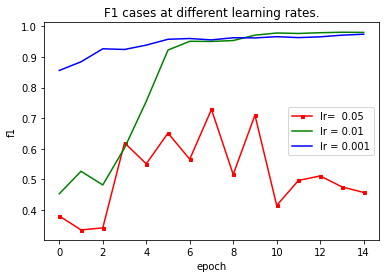

In [ ]:
#  x是epoch y是f1 测试集  command+/
import matplotlib.pyplot as plt
#for epoch in range(total_epoch):  
#x = [5, 10, 15, 20, 25, 30, 35, 40]
#y = [17, 24, 29, 36, 38, 47, 59, 80]
#[1,0.5,0.1,0.05,0.01,0.005,0.001] // [0.05,0.01,0.005,0.001]
x = [epoch for epoch in range(total_epoch)]
y1 = [f1 for f1 in line_lr[0]]
y2 = [f1 for f1 in line_lr[1]]
y3 = [f1 for f1 in line_lr[2]]
#y4 = [f1 for f1 in line_lr[3]]
# y5 = [f1 for f1 in line_lr[4]]
# y6 = [f1 for f1 in line_lr[5]]
# y7 = [f1 for f1 in line_lr[6]]
plt.plot(x,y1,'rs-',markersize =3,label = 'lr=  0.05') # 那个点  红色尺寸点

plt.plot(x,y2,'g-',markersize =3, label = 'lr = 0.01') # 那个点  红色尺寸点
plt.plot(x,y3,'b-',markersize =3, label = 'lr = 0.001') # 那个点  红色尺寸点      #0.005
#plt.plot(x,y4,'y-',markersize =3, label = 'lr = 0.005') # 那个点  红色尺寸点     #0.001
# plt.plot(x,y5,'c-',markersize =3, label = 'lr = 0.01') # 那个点  红色尺寸点
# plt.plot(x,y6,'m-',markersize =3, label = 'lr = 0.005') # 那个点  红色尺寸点
# plt.plot(x,y7,'k-',markersize =3, label = 'lr = 0.001') # 那个点  红色尺寸点
plt.xlabel('epoch')
plt.ylabel('f1')
plt.title('F1 cases at different learning rates.')
plt.legend() #让标签显示出来
plt.show()
# precision: TP/(TP+FP)
#recall

In [ ]:
# criterion = nn.CrossEntropyLoss()
# model = Bi_LSTM_Model().to(device)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# for epoch in range(total_epoch):
#     train_loss = 0
#     for ind in range(0,sent_encoded_train.shape[0],batch_size):
#         input_batch = sent_encoded_train[ind:min(ind+batch_size, sent_encoded_train.shape[0])] #256,22,101
#         target_batch = label_train[ind:min(ind+batch_size, sent_encoded_train.shape[0])]  #256
#         input_batch_torch = torch.from_numpy(input_batch).float().to(device)  #256,22,101
#         target_batch_torch = torch.from_numpy(target_batch).view(-1).to(device) #256

#         model.train()
#         optimizer.zero_grad()
#         outputs = model(input_batch_torch)   #13,512,25 #256，22，101    #256 2 #500,22,101
#         loss = criterion(outputs, target_batch_torch) #256 2    256 out,y
#         loss.backward()
#         optimizer.step()
        
#         train_loss += loss.item()
#     predicted = torch.argmax(outputs, 1)  # 输出值为元祖获取第二个tensor        
#     acc = accuracy_score(predicted.cpu().numpy(),target_batch_torch.cpu().numpy())
#     #print('Epoch: %d, train loss: %.5f, train_acc:%.2f'%(epoch + 1, train_loss, acc))

# #print('Finished Training')
# #这块是在后面评估，可删
# ## Prediction

# model.eval()
# outputs2 = model(torch.from_numpy(sent_encoded_test).float().to(device)) 
# predicted2 = torch.argmax(outputs2, 1)


# print(classification_report(label_test, predicted2.cpu().numpy(),digits=4))
# #是改变了batch